# Project Report: Mask R-CNN for Tiger and Lion Detection

## Hyperparamètres utilisés

Les hyperparamètres utilisés pour l'entraînement du modèle Mask R-CNN sont les suivants :

#### Configuration générale :
- **Nom du modèle** : `object`  
- **Nombre de GPU** : `1`  
- **Nombre d'images par GPU** : `1`  
- **Nombre de classes** : `3` (Fond + Lion + Tigre)  
- **Dimensions des images** : `512 x 512`  
- **Nombre d'étapes par époque** : `100`  
- **Nombre d'étapes de validation** : `5`  

#### Détection et ancrage :
- **Confiance minimale de détection** : `0.9`  
- **Échelles des ancres RPN** : `(16, 32, 64, 128, 256)`  

#### Optimisation :
- **Taux d'apprentissage (learning rate)** : `0.001`  

#### Points à noter :
- Les paramètres ont été choisis en fonction de la taille du dataset, des capacités matérielles, et des tests pour obtenir un bon compromis entre vitesse d'exécution et performance. 
- Les dimensions des images ont été réduites à `512 x 512` pour permettre un entraînement efficace tout en maintenant une qualité suffisante pour les détections.




### Setup and Initialization of the Environment for Mask R-CNN

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Root directory of the project
ROOT_DIR = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master"

DEFAULT_LOGS_DIR = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs"
MODEL_DIR = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs"
WEIGHTS_PATH = r"C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\logs\object20241109T2151/mask_rcnn_object_0010.h5"


Using TensorFlow backend.


### Custom Configuration and Dataset Class for Mask R-CNN

In [2]:
class CustomConfig(Config):
    """Configuration for training on the custom dataset."""
    NAME = "object"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 2  # Background + tiger and lion
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    LEARNING_RATE = 0.001
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    VALIDATION_STEPS = 5


class CustomDataset(utils.Dataset):
    """Custom dataset for loading images and masks with annotations."""

    def load_custom(self, dataset_dir, subset):
        """
        Load a subset of the custom dataset.

        Args:
            dataset_dir (str): Path to the dataset directory.
            subset (str): Subdirectory name (e.g., 'train' or 'val').
        """
        # Add class labels
        self.add_class("object", 1, "lion")
        self.add_class("object", 2, "tigre")

        json_dir = os.path.join(dataset_dir, subset, "json")
        for filename in os.listdir(json_dir):
            if filename.endswith(".json"):
                file_path = os.path.join(json_dir, filename)

                # Load JSON annotations
                with open(file_path, 'r') as f:
                    data = json.load(f)

                # Resolve image path
                image_filename = os.path.basename(data['imagePath'])
                image_path = os.path.join(dataset_dir, subset, image_filename)

                # Check if the image exists
                if not os.path.exists(image_path):
                    continue

                height = data.get('imageHeight')
                width = data.get('imageWidth')
                if not height or not width:
                    continue

                # Extract polygons and object labels
                polygons = [shape['points'] for shape in data['shapes']]
                objects = [shape['label'] for shape in data['shapes']]

                # Map labels to numeric IDs
                name_dict = {"lion": 1, "tigre": 2}
                try:
                    num_ids = [name_dict[obj] for obj in objects]
                except KeyError:
                    continue

                # Validate polygons
                valid_polygons = []
                valid_num_ids = []
                for i, polygon in enumerate(polygons):
                    all_points_y = [point[1] for point in polygon]
                    all_points_x = [point[0] for point in polygon]
                    if max(all_points_x) >= width or max(all_points_y) >= height:
                        continue
                    valid_polygons.append(polygon)
                    valid_num_ids.append(num_ids[i])

                if not valid_polygons:
                    continue

                # Add image to the dataset
                self.add_image(
                    "object",
                    image_id=image_filename,
                    path=image_path,
                    width=width,
                    height=height,
                    polygons=valid_polygons,
                    num_ids=valid_num_ids
                )

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.

        Args:
            image_id (int): ID of the image to load masks for.

        Returns:
            tuple: A binary mask array and an array of class IDs.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        num_ids = info['num_ids']
        height, width = info["height"], info["width"]
        mask = np.zeros((height, width, len(info["polygons"])), dtype=np.uint8)

        for i, polygon in enumerate(info["polygons"]):
            all_points_y = [point[1] for point in polygon]
            all_points_x = [point[0] for point in polygon]
            rr, cc = skimage.draw.polygon(all_points_y, all_points_x)
            mask[rr, cc, i] = 1

        return mask, np.array(num_ids, dtype=np.int32)

    def image_reference(self, image_id):
        """
        Return the path of the image.

        Args:
            image_id (int): ID of the image.

        Returns:
            str: Path to the image.
        """
        info = self.image_info[image_id]
        return info["path"] if info["source"] == "object" else super(self.__class__, self).image_reference(image_id)


### Loading and Preparing the Validation Dataset for Inference

In [3]:
# Charger le dataset de validation
dataset_val = CustomDataset()
dataset_val.load_custom(os.path.join(ROOT_DIR, "dataset"), "val")
dataset_val.prepare()

# Configurer le modèle pour l'inférence
config = CustomConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=DEFAULT_LOGS_DIR, config=config)

# Charger les poids entraînés
WEIGHTS_PATH = r"C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\logs\object20241109T2151\mask_rcnn_object_0010.h5"  
if not os.path.exists(WEIGHTS_PATH):
    raise FileNotFoundError(f"Le fichier de poids {WEIGHTS_PATH} n'existe pas.")

model.load_weights(WEIGHTS_PATH, by_name=True)

print("[INFO] Poids chargés avec succès à partir de :", WEIGHTS_PATH)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 10
[INFO] Poids chargés avec succès à partir de : C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\logs\object20241109T2151\mask_rcnn_object_0010.h5


# Displaying Masks and Bounding Boxes on a Training Dataset Image

Shape of mask: (726, 799, 3)
Class IDs: [2 2 2]
Unique mask values: [0 1]
Bounding boxes: [[ 36  36 701 781]
 [500   5 723 461]
 [308 668 566 795]]
Shape of mask: (234, 312, 2)
Class IDs: [2 2]
Unique mask values: [0 1]
Bounding boxes: [[  0   0 205 300]
 [  0   0   0   0]]
Shape of mask: (360, 1156, 1)
Class IDs: [2]
Unique mask values: [0 1]
Bounding boxes: [[   1   10  358 1128]]
Shape of mask: (708, 1024, 1)
Class IDs: [1]
Unique mask values: [0 1]
Bounding boxes: [[274 256 626 974]]
Shape of mask: (681, 1024, 1)
Class IDs: [1]
Unique mask values: [0 1]
Bounding boxes: [[265 419 515 566]]
Shape of mask: (412, 693, 1)
Class IDs: [2]
Unique mask values: [0 1]
Bounding boxes: [[ 63  19 410 650]]
Shape of mask: (678, 1024, 2)
Class IDs: [1 1]
Unique mask values: [0 1]
Bounding boxes: [[   1    3  641 1022]
 [   1  336  639 1022]]
Shape of mask: (680, 1024, 2)
Class IDs: [1 1]
Unique mask values: [0 1]
Bounding boxes: [[199   0 678 944]
 [215   1 631 290]]
Shape of mask: (678, 1024, 1)


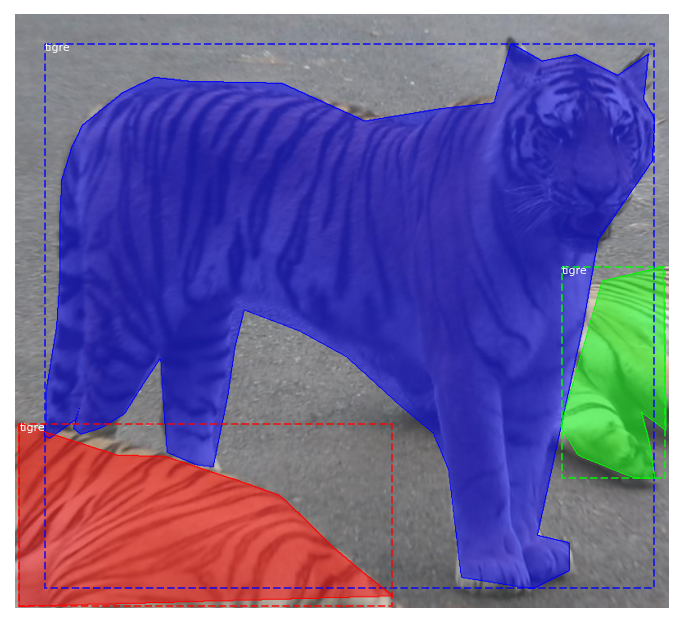

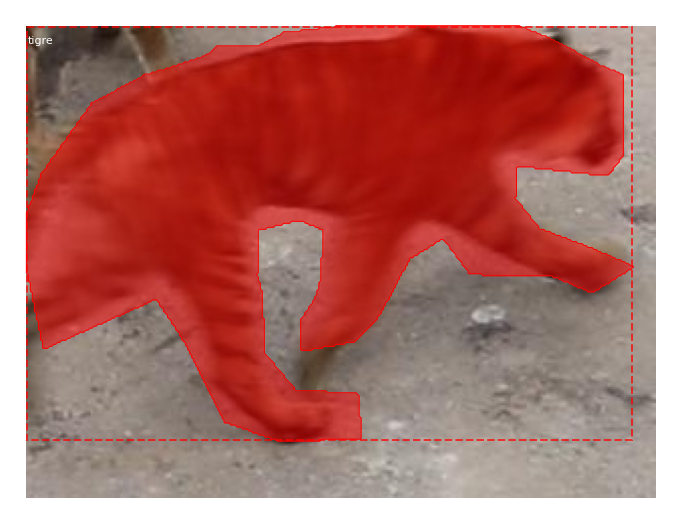

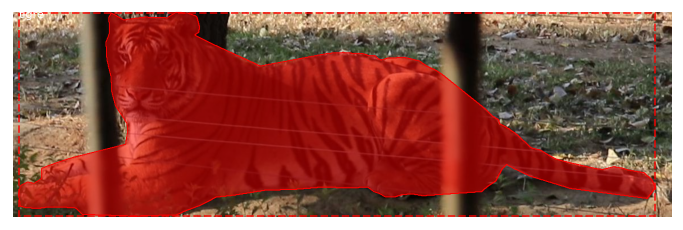

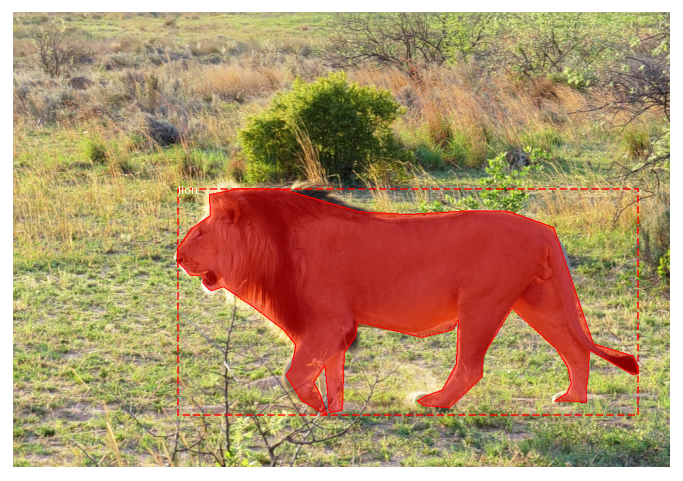

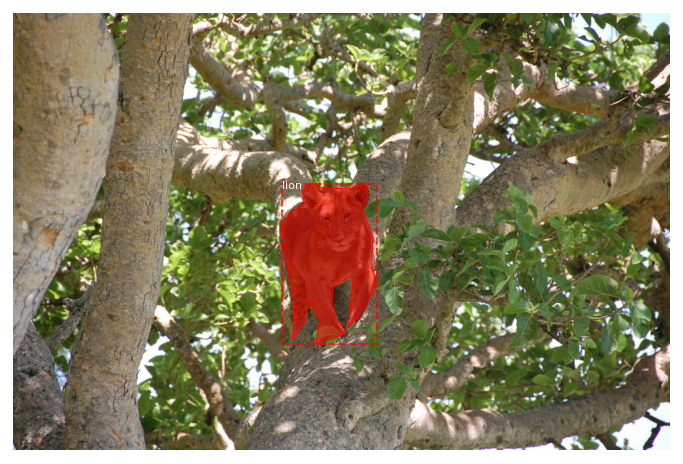

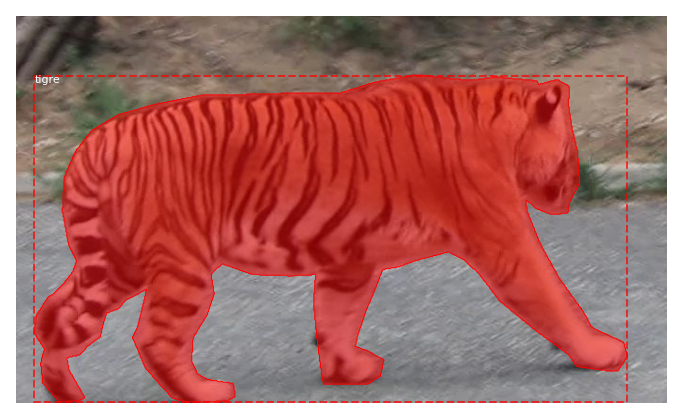

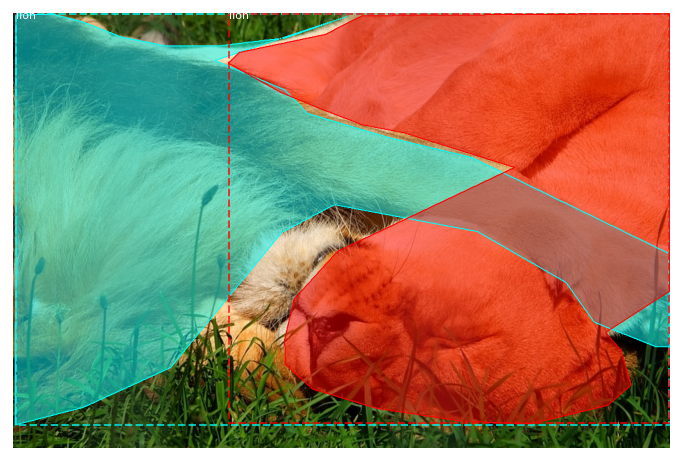

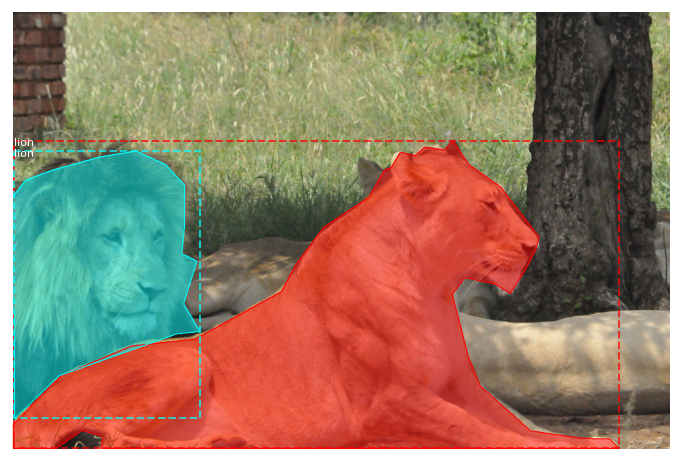

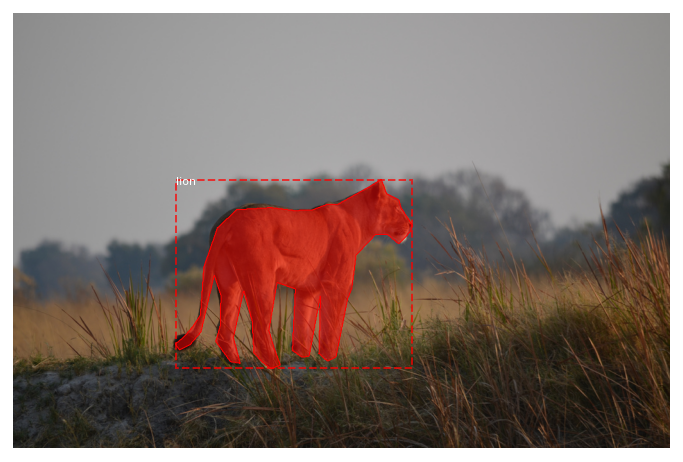

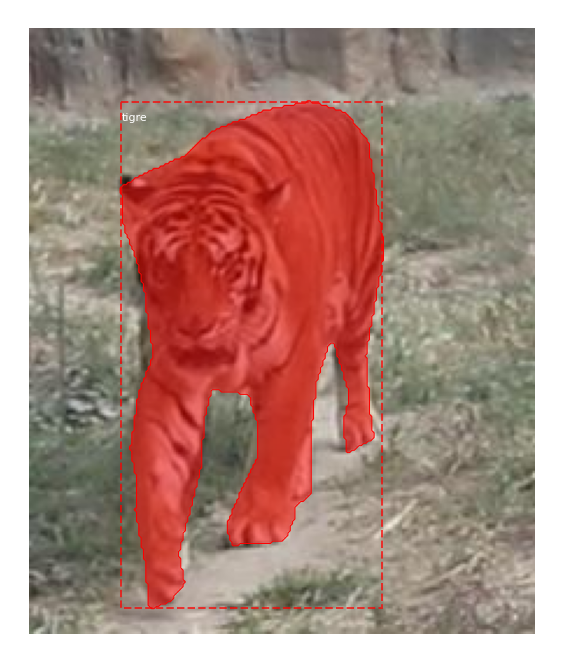

In [20]:
import numpy as np
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

# Définir extract_bboxes pour générer des bounding boxes à partir des masques
def extract_bboxes(mask):
    """Compute bounding boxes from masks."""
    bboxes = np.zeros((mask.shape[-1], 4), dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        horizontal_indices = np.where(np.any(m, axis=0))[0]
        vertical_indices = np.where(np.any(m, axis=1))[0]
        if horizontal_indices.shape[0]:
            x1, x2 = horizontal_indices[[0, -1]]
            y1, y2 = vertical_indices[[0, -1]]
            bboxes[i] = [y1, x1, y2, x2]
    return bboxes

# Charger le dataset d'entraînement
dataset_train = CustomDataset()
dataset_train.load_custom(os.path.join(ROOT_DIR, "dataset"), "train")
dataset_train.prepare()

# Définir les noms des classes
class_names = ["BG", "lion", "tigre"]

# Convertir image_ids en une liste explicite
image_ids = list(dataset_train.image_ids)

# Afficher 10 images aléatoires
num_images_to_display = 10
selected_image_ids = random.sample(image_ids, num_images_to_display)

for image_id in selected_image_ids:
    # Charger l'image et les masques
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

    print(f"Shape of mask: {mask.shape}")
    print(f"Class IDs: {class_ids}")
    print(f"Unique mask values: {np.unique(mask)}")

    if mask.shape[-1] > 0 and len(class_ids) > 0:
        # Générez les bounding boxes
        boxes = extract_bboxes(mask)
        print(f"Bounding boxes: {boxes}")

        # Afficher l'image avec les masques et les classes
        _, ax = plt.subplots(1, figsize=(12, 12))
        display_instances(image, boxes, mask, class_ids, class_names, ax=ax)
    else:
        print("[AVERTISSEMENT] Pas de masque ou de classe valide pour cette image.")


# Test/Production Images

## Detection Test : Tiger and Lion

Processing 1 images
image                    shape: (800, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


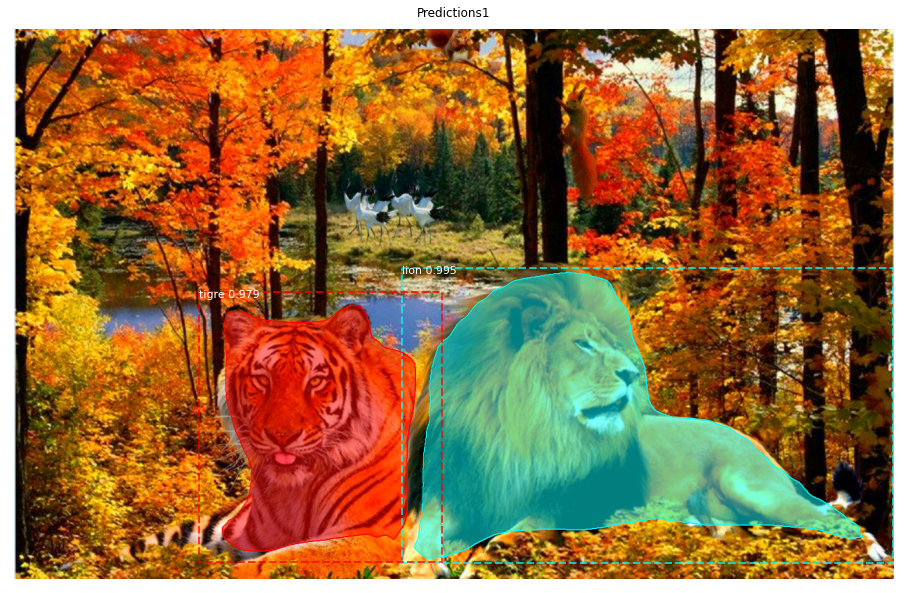

In [23]:
# Define get_ax function
def get_ax(rows=1, cols=1, size=16):
    """Returns a Matplotlib Axes array to be used in visualizations.
    Adjust the size attribute to control the size of rendered images.
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

# Test on new image
path_to_new_image = r"C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\img_test\image.jpg"
image1 = mpimg.imread(path_to_new_image)
results1 = model.detect([image1], verbose=1)
r1 = results1[0]

ax = get_ax(1)
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset_val.class_names, r1['scores'], ax=ax, title="Predictions1")



## Detection Test : Tiger


Processing 1 images
image                    shape: (2312, 3532, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 3532.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


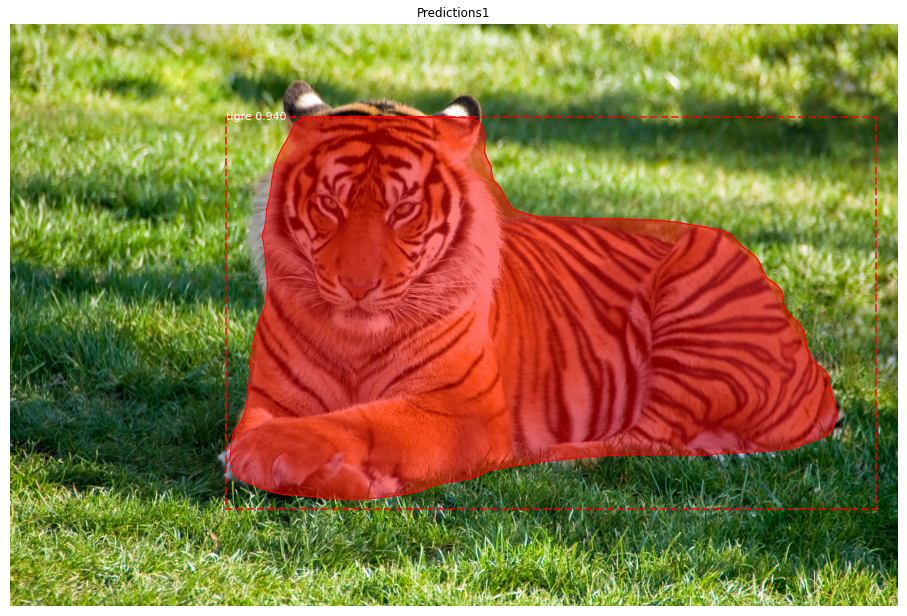

In [59]:
# Define get_ax function
def get_ax(rows=1, cols=1, size=16):
    """Returns a Matplotlib Axes array to be used in visualizations.
    Adjust the size attribute to control the size of rendered images.
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

# Test on new image
path_to_new_image = r"C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\img_test\test3.jpg"
image1 = mpimg.imread(path_to_new_image)
results1 = model.detect([image1], verbose=1)
r1 = results1[0]

ax = get_ax(1)
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset_val.class_names, r1['scores'], ax=ax, title="Predictions1")



## Detection Test : Lion


Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


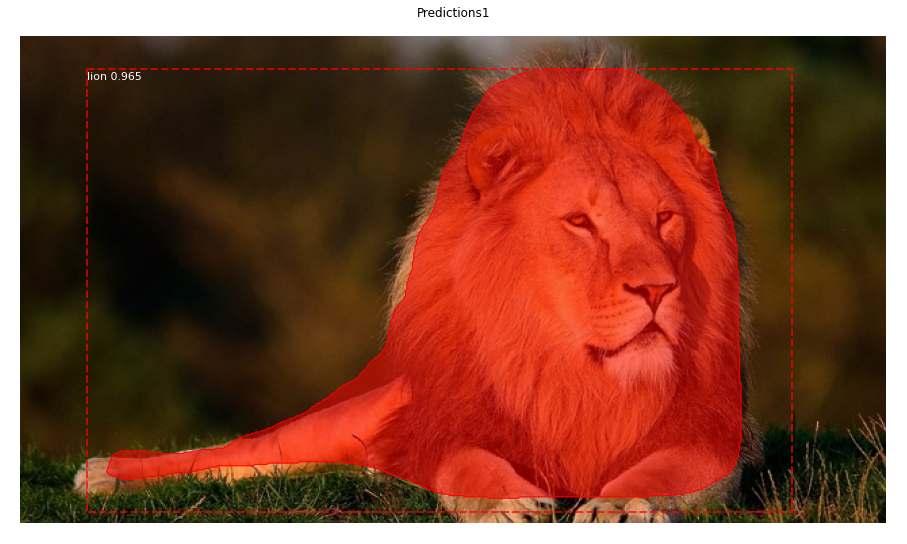

In [58]:
# Define get_ax function
def get_ax(rows=1, cols=1, size=16):
    """Returns a Matplotlib Axes array to be used in visualizations.
    Adjust the size attribute to control the size of rendered images.
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

# Test on new image
path_to_new_image = r"C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\img_test\test4.jpg"
image1 = mpimg.imread(path_to_new_image)
results1 = model.detect([image1], verbose=1)
r1 = results1[0]

ax = get_ax(1)
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset_val.class_names, r1['scores'], ax=ax, title="Predictions1")



# Confusion Matrix

[AVERTISSEMENT] Mismatch in lengths: true_labels = 70, pred_labels = 67
Total des vérités terrain utilisées: 67
Total des prédictions utilisées: 67


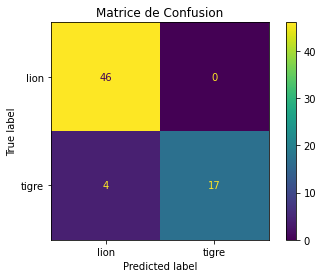

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Charger le dataset de validation
CUSTOM_DIR = r"C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/dataset"
dataset_val = CustomDataset()
dataset_val.load_custom(CUSTOM_DIR, "val")  # Charger les données de validation
dataset_val.prepare()

config = CustomConfig()

# Initialisation des listes pour les vérités terrain et les prédictions
true_labels = []  # Les étiquettes réelles
pred_labels = []  # Les étiquettes prédites

# Parcourir toutes les images de validation
for image_id in dataset_val.image_ids:
    try:
        # Charger l'image et les annotations associées
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
            dataset_val, config, image_id, use_mini_mask=False
        )
    except Exception as e:
        print(f"[ERREUR] Problème avec l'image ID {image_id} : {e}")
        continue

    # Obtenir les prédictions du modèle
    results = model.detect([image], verbose=0)
    r = results[0]

    # Filtrer les prédictions par confiance minimale
    filtered_class_ids = [class_id for i, class_id in enumerate(r['class_ids']) if r['scores'][i] >= config.DETECTION_MIN_CONFIDENCE]

    # Ajouter les vérités terrain et les prédictions
    true_labels.extend(list(gt_class_id))
    pred_labels.extend(filtered_class_ids)

    # Imprimer les détails pour chaque image
#     print(f"Image ID: {image_id}")
#     print(f"  Vérités terrain (gt_class_id): {gt_class_id}")
#     print(f"  Prédictions (class_ids): {r['class_ids']}")
#     print(f"  Prédictions filtrées (scores >= {config.DETECTION_MIN_CONFIDENCE}): {filtered_class_ids}")

# Vérifier et ajuster les longueurs pour correspondre
if len(true_labels) != len(pred_labels):
    print(f"[AVERTISSEMENT] Mismatch in lengths: true_labels = {len(true_labels)}, pred_labels = {len(pred_labels)}")
    min_length = min(len(true_labels), len(pred_labels))
    true_labels, pred_labels = true_labels[:min_length], pred_labels[:min_length]

# Imprimer le nombre total de vérités terrain et de prédictions utilisées
print(f"Total des vérités terrain utilisées: {len(true_labels)}")
print(f"Total des prédictions utilisées: {len(pred_labels)}")

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=range(1, len(dataset_val.class_names)))

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset_val.class_names[1:])
disp.plot(cmap="viridis")
plt.title("Matrice de Confusion")
plt.show()


# TensorBoard Log Exploration and Extraction

In [23]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Spécifiez le chemin du répertoire contenant les logs
log_dir = r"C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\logs\object20241109T2151"

# Cherchez les fichiers de log dans le répertoire
log_files = [os.path.join(log_dir, file) for file in os.listdir(log_dir) if file.startswith("events.out.tfevents")]

if not log_files:
    print("Aucun fichier de log trouvé dans le répertoire spécifié.")
else:
    for log_file in log_files:
        print(f"Fichier de log trouvé : {log_file}")

        # Charger le fichier de log
        event_acc = EventAccumulator(log_file)
        event_acc.Reload()

        # Lister toutes les métriques disponibles
        print("\nMétriques disponibles :")
        for tag in event_acc.Tags()['scalars']:
            print(f" - {tag}")

        # Afficher les valeurs enregistrées pour chaque métrique
        for tag in event_acc.Tags()['scalars']:
            print(f"\nValeurs pour la métrique : {tag}")
            events = event_acc.Scalars(tag)
            for e in events:
                print(f"Step: {e.step}, Value: {e.value}")

        print("\n--- Fin du fichier de log ---\n")


Fichier de log trouvé : C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\logs\object20241109T2151\events.out.tfevents.1731185483.JB

Métriques disponibles :
 - val_loss
 - val_rpn_class_loss
 - val_rpn_bbox_loss
 - val_mrcnn_class_loss
 - val_mrcnn_bbox_loss
 - val_mrcnn_mask_loss
 - loss
 - rpn_class_loss
 - rpn_bbox_loss
 - mrcnn_class_loss
 - mrcnn_bbox_loss
 - mrcnn_mask_loss

Valeurs pour la métrique : val_loss
Step: 0, Value: 0.5820412635803223

Valeurs pour la métrique : val_rpn_class_loss
Step: 0, Value: 0.007850730791687965

Valeurs pour la métrique : val_rpn_bbox_loss
Step: 0, Value: 0.2375071793794632

Valeurs pour la métrique : val_mrcnn_class_loss
Step: 0, Value: 0.021565284579992294

Valeurs pour la métrique : val_mrcnn_bbox_loss
Step: 0, Value: 0.16101408004760742

Valeurs pour la métrique : val_mrcnn_mask_loss
Step: 0, Value: 0.1541024148464203

Valeurs pour la métrique : loss
Step: 0, Value: 1.437284231185913

Valeurs pour la métrique : rpn_class_loss
Step:


Métriques disponibles :
 - val_loss
 - val_rpn_class_loss
 - val_rpn_bbox_loss
 - val_mrcnn_class_loss
 - val_mrcnn_bbox_loss
 - val_mrcnn_mask_loss
 - loss
 - rpn_class_loss
 - rpn_bbox_loss
 - mrcnn_class_loss
 - mrcnn_bbox_loss
 - mrcnn_mask_loss

Valeurs pour la métrique : val_loss
Step: 6, Value: 0.6869074702262878

Valeurs pour la métrique : val_rpn_class_loss
Step: 6, Value: 0.004315394442528486

Valeurs pour la métrique : val_rpn_bbox_loss
Step: 6, Value: 0.26782894134521484

Valeurs pour la métrique : val_mrcnn_class_loss
Step: 6, Value: 0.016988852992653847

Valeurs pour la métrique : val_mrcnn_bbox_loss
Step: 6, Value: 0.16429078578948975

Valeurs pour la métrique : val_mrcnn_mask_loss
Step: 6, Value: 0.23348195850849152

Valeurs pour la métrique : loss
Step: 6, Value: 0.3582920730113983

Valeurs pour la métrique : rpn_class_loss
Step: 6, Value: 0.0040150596760213375

Valeurs pour la métrique : rpn_bbox_loss
Step: 6, Value: 0.1261187344789505

Valeurs pour la métrique : mrc

# Training and Validation Loss Graph

Lecture du fichier : C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241109T2151\events.out.tfevents.1731185483.JB
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Lecture du fichier : C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241109T2151\events.out.tfevents.1731190298.JB
Lecture du fichier : C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241109T2151\events.out.tfevents.1731195042.JB
Lecture du fichier : C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241109T2151\events.out.tfevents.1731199797.JB
Lecture du fichier : C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241109T2151\events.out.tfevents.1731204591.JB
Lecture du fichier : C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241109T2151\events.out.tfevents.1731209388.JB
Lecture du fichier : C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask

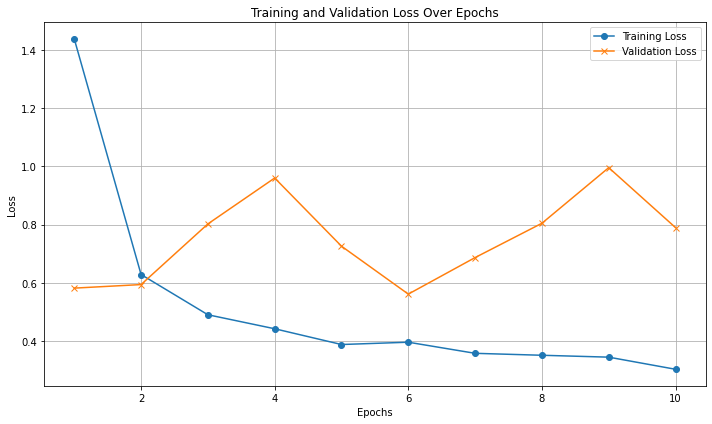

In [10]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Dossier contenant les fichiers events
EVENTS_DIR = "C:/M1 MASERTI/GPIA/IA/environnement_virtuel/Mask_RCNN-master/logs/object20241109T2151"

# Initialisation des listes pour les données
epochs = []
train_losses = []
val_losses = []

# Lecture de tous les fichiers events dans le dossier
for filename in os.listdir(EVENTS_DIR):
    if filename.startswith("events.out.tfevents"):
        filepath = os.path.join(EVENTS_DIR, filename)
        print(f"Lecture du fichier : {filepath}")
        for event in tf.compat.v1.train.summary_iterator(filepath):
            for value in event.summary.value:
                if value.tag == 'loss':  # Tag pour la perte d'entraînement
                    train_losses.append(value.simple_value)
                    epochs.append(len(train_losses))  # Ajout de l'index comme numéro d'époque
                elif value.tag == 'val_loss':  # Tag pour la perte de validation
                    val_losses.append(value.simple_value)

# Vérification des données extraites
print("Époques:", epochs)
print("Pertes d'entraînement:", train_losses)
print("Pertes de validation:", val_losses)

# Graphique des pertes
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
if val_losses:
    plt.plot(epochs[:len(val_losses)], val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("consolidated_loss_graph.png")  # Sauvegarde du graphique
plt.show()


## Dernières métriques de l'entraînement et de la validation (Step 9)

In [7]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Spécification le chemin de votre fichier de log
log_file_path = r"C:\M1 MASERTI\GPIA\IA\environnement_virtuel\Mask_RCNN-master\logs\object20241109T2151"

# Localisation le fichier `events.out.tfevents`
log_files = [os.path.join(log_file_path, f) for f in os.listdir(log_file_path) if f.startswith("events.out.tfevents")]

if not log_files:
    print("Aucun fichier de log trouvé.")
else:
    # Chargement du fichier de log
    log_file = log_files[-1]  # Le dernier fichier log trouvé
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    # Liste de toutes les métriques disponibles
    available_metrics = event_acc.Tags()["scalars"]
    print(f"Métriques disponibles : {available_metrics}")

    # Récupération des valeurs des métriques pour la dernière epoch
    print("\nDernières valeurs des métriques :")
    for metric in available_metrics:
        events = event_acc.Scalars(metric)
        if events:  # Vérifions qu'il y a des données pour cette métrique
            last_event = events[-1]
            print(f"{metric} - Step : {last_event.step}, Value : {last_event.value}")


Métriques disponibles : ['val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss', 'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss', 'loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_bbox_loss', 'mrcnn_mask_loss']

Dernières valeurs des métriques :
val_loss - Step : 9, Value : 0.7897121906280518
val_rpn_class_loss - Step : 9, Value : 0.003921102732419968
val_rpn_bbox_loss - Step : 9, Value : 0.4299398362636566
val_mrcnn_class_loss - Step : 9, Value : 0.016725270077586174
val_mrcnn_bbox_loss - Step : 9, Value : 0.14361178874969482
val_mrcnn_mask_loss - Step : 9, Value : 0.1955125629901886
loss - Step : 9, Value : 0.30350226163864136
rpn_class_loss - Step : 9, Value : 0.002676386618986726
rpn_bbox_loss - Step : 9, Value : 0.09666182100772858
mrcnn_class_loss - Step : 9, Value : 0.009530656039714813
mrcnn_bbox_loss - Step : 9, Value : 0.051803864538669586
mrcnn_mask_loss - Step : 9, Value : 0.14282792806625366


## Difficultés rencontrées

## Difficultés rencontrées

Nous, **Jean-Baptiste Chèze** et **Alpha Diallo**, avons rencontré plusieurs défis tout au long de ce projet.

- **Gestion des fichiers JSON :** Charger et parser les annotations des images a été plus compliqué que prévu. Certains fichiers présentaient des problèmes comme des dimensions manquantes ou des polygones aux coordonnées hors limites. Il a fallu vérifier chaque étape pour s'assurer que les données étaient correctement utilisées.

- **Compatibilité des librairies :** Pour que le projet fonctionne, il a été nécessaire de rétrograder toutes les librairies à des versions datant de 2017, notamment TensorFlow et Keras. Cette étape a pris du temps et a demandé plusieurs ajustements pour que tout soit compatible avec Mask R-CNN.

- **Matrice de confusion :** Nous avons rencontré des difficultés dans le calcul de la matrice de confusion. La gestion des prédictions et des vérités terrain (ground truths) n'était pas toujours alignée, ce qui a nécessité plusieurs essais et ajustements pour obtenir des résultats fiables.

Malgré ces difficultés, ce projet nous a permis d'approfondir nos connaissances sur la gestion des données, la configuration d'un environnement de deep learning, et l'évaluation des performances d'un modèle. Cela restera une expérience très formatrice.


